## import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import PIL.Image as Image
from PIL import ImageOps
import os
import glob as glob

import tensorflow as tf
from keras import layers, models, callbacks
from keras.models import Sequential, Model
from keras.utils import load_img, normalize
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, AveragePooling2D
from keras.layers import Concatenate, concatenate, BatchNormalization, Dropout, Lambda, Activation
from keras.applications import ResNet50

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import random
from IPython.display import Image, display

from keras.models import Model
from keras import backend as K

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Prepare paths of input images and target segmentation masks for train and test set

In [2]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CLASSES = 5
IMG_CHANNELS = 3

IMG_PATH = '/kaggle/input/oil-spill/oil-spill/train/images'
LABELS_PATH = '/kaggle/input/oil-spill/oil-spill/train/labels'

IMG_PATH_TEST = '/kaggle/input/oil-spill/oil-spill/test/images'
LABELS_PATH_TEST = '/kaggle/input/oil-spill/oil-spill/test/labels'

In [3]:
# Get a list of all image filenames in the directory
IMG_IDS = sorted(os.listdir(IMG_PATH))
LABELS_IDS = sorted(os.listdir(LABELS_PATH))

IMG_IDS_TEST = sorted(os.listdir(IMG_PATH_TEST))
LABELS_IDS_TEST = sorted(os.listdir(LABELS_PATH_TEST))

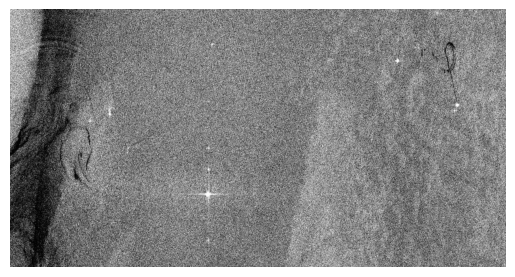

Randomly selected image: img_0006.jpg


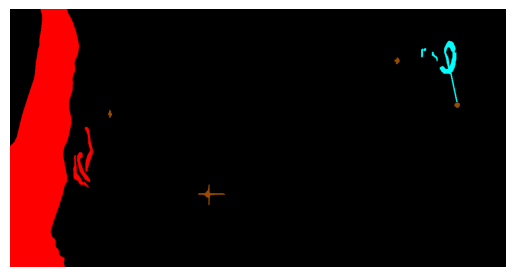

Randomly selected mask: img_0006.png


In [4]:
# Choose a random image and mask filename from the list
random_image_name = IMG_IDS[5]
random_mask_name = LABELS_IDS[5]

# Construct the full image path
image_path = os.path.join(IMG_PATH, random_image_name)
mask_path = os.path.join(LABELS_PATH, random_mask_name)

# Read and plot the image
img = mpimg.imread(image_path)
mask = mpimg.imread(mask_path)

plt.imshow(img)
plt.axis('off')
plt.show()

print("Randomly selected image:", random_image_name)

plt.imshow(mask)
plt.axis('off')
plt.show()

print("Randomly selected mask:", random_mask_name)

In [5]:
def process_mask(rgb_mask, colormap):
    output_mask = []

    for i, color in enumerate(colormap):
        cmap = np.all(np.equal(rgb_mask, color), axis=-1)
        output_mask.append(cmap)

    output_mask = np.stack(output_mask, axis=-1)
    return output_mask

In [6]:
COLOR_MAP = [
    [0, 0, 0], 
    [0, 255, 255], 
    [255, 0, 0], 
    [153, 76, 0],
    [0, 153, 0],
]

In [7]:
train_images = []
train_masks = []

test_images = []
test_masks = []

### train set

In [8]:
for image_filename, mask_filename in tqdm(zip(IMG_IDS, LABELS_IDS),total = len(IMG_IDS)):
    image_path = os.path.join(IMG_PATH, image_filename)
    mask_path = os.path.join(LABELS_PATH, mask_filename)

    image = cv2.imread(image_path,cv2.IMREAD_COLOR)

    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    
    # normalizing the image
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    processed_mask = process_mask(mask,COLOR_MAP)
    grayscale_mask = np.argmax(processed_mask, axis=-1)
    grayscale_mask = np.expand_dims(grayscale_mask, axis=-1)

    train_images.append(image)
    train_masks.append(grayscale_mask)

# Convert the lists to arrays
train_images = np.array(train_images)
train_masks = np.array(train_masks)

100%|██████████| 1002/1002 [00:41<00:00, 23.97it/s]


### test set

In [9]:
for image_filename, mask_filename in tqdm(zip(IMG_IDS_TEST, LABELS_IDS_TEST),total = len(IMG_IDS_TEST)):
    image_path = os.path.join(IMG_PATH_TEST, image_filename)
    mask_path = os.path.join(LABELS_PATH_TEST, mask_filename)

    image = cv2.imread(image_path,cv2.IMREAD_COLOR)

    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    
    # normalizing the image
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    processed_mask = process_mask(mask,COLOR_MAP)
    grayscale_mask = np.argmax(processed_mask, axis=-1)
    grayscale_mask = np.expand_dims(grayscale_mask, axis=-1)

    test_images.append(image)
    test_masks.append(grayscale_mask)

# Convert the lists to np arrays
test_images = np.array(test_images)
test_masks = np.array(test_masks)

100%|██████████| 110/110 [00:04<00:00, 22.53it/s]


## Using to_categorical for the masks

In [10]:
from keras.utils import to_categorical

train_masks = to_categorical(train_masks, num_classes = 5)

In [11]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# UNet Model

In [ ]:
def UNet(input_shape, IMG_CLASSES):

    inputs = Input(input_shape)

    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

    outputs = Conv2D(IMG_CLASSES, (1,1), activation="softmax")(c9)

    model = Model(inputs, outputs)
    return model

In [ ]:
model = UNet(input_shape, IMG_CLASSES)

model.summary()

In [ ]:
tf.keras.backend.clear_session()

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics='accuracy')

## Train the model

In [ ]:
history = model.fit(train_images, train_masks,
                    epochs=100,
                    batch_size=16,
                    validation_split=0.1,
                    verbose=1)

## prediction visualisation

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'c', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
y_pred_unet = model.predict(test_images)
y_pred_unet_argmax = np.argmax(y_pred_unet, axis=-1)

In [ ]:
y_test = to_categorical(test_masks, num_classes = 5)
y_test_argmax = np.argmax(y_test, axis=3)

## model evaluation

In [ ]:
_, acc = model.evaluate(test_images, y_pred_unet)
print("Accuracy is = ", (acc * 100.0), "%")

## prediciton visualization

In [ ]:
# Generate a random index within the range of test_images
test_image_number = random.randint(0, len(test_images) - 1)

# Retrieve the test image and its corresponding ground truth
test_image = test_images[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

# Expand dimensions of the test image to match the model input shape
test_image_input = np.expand_dims(test_image, axis=0)

# Get the model's prediction for the test image
prediction = model.predict(test_image_input)

# Find the index of the highest predicted value along the channel axis
predicted_image = np.argmax(prediction, axis=3)[0, :, :]

# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the original image
axes[0].imshow(test_image)
axes[0].set_title("Original Image")
axes[0].axis('off')  # Turn off axis labels

# Plot the original masked image
axes[1].imshow(ground_truth_image)
axes[1].set_title("Original Masked Image")
axes[1].axis('off')  # Turn off axis labels

# Plot the predicted image
axes[2].imshow(predicted_image)
axes[2].set_title("Predicted Image")
axes[2].axis('off')  # Turn off axis labels

# Adjust layout and spacing
plt.tight_layout()

# Display the plot
plt.show()

# DeepLapV3 Model

In [ ]:
# atrous_spatial_pyramid_pooling
def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

In [ ]:
def DeepLabV3Plus(input_shape, IMG_CLASSES):
    # Inputs
    inputs = layers.Input(input_shape)

    # Pre-trained ResNet50
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    # Pre-trained ResNet50 Output
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    # Get low-level features
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    # Outputs
    x = Conv2D(IMG_CLASSES, (1, 1), name='output_layer')(x)
    x = Activation('softmax')(x)

    # Model
    model = Model(inputs=inputs, outputs=x)
    return model

In [ ]:
deeplab_model = DeepLabV3Plus(input_shape, IMG_CLASSES)
deeplab_model.summary()

In [12]:
def jaccard_coef(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value

In [13]:
# treating all classes equally in terms of their contribution to the loss.
class_weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [14]:
!pip install -U -q segmentation-models
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

dice_loss = sm.losses.DiceLoss(class_weights = class_weights)
focal_loss = sm.losses.CategoricalFocalLoss()

total_loss = dice_loss + focal_loss

Segmentation Models: using `tf.keras` framework.


In [ ]:
tf.keras.backend.clear_session()

# # Define the learning rate
# learning_rate = 10e-5

# # Create an instance of the Adam optimizer with the specified learning rate
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

deeplab_model.compile(optimizer='adam', loss=total_loss, metrics = ["accuracy", jaccard_coef])

In [ ]:
history = deeplab_model.fit(train_images, train_masks,
                            epochs=50,
                            batch_size=16,
                            validation_split=0.1,
                            verbose=1)

## model visualization

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'c', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
y_pred_deeplab = deeplab_model.predict(test_images)
y_pred_deeplab_argmax = np.argmax(y_pred_deeplab, axis=-1)

In [ ]:
y_test = to_categorical(test_masks, num_classes = 5)
y_test_argmax = np.argmax(y_test, axis=3)

## model evaluation

In [ ]:
_, acc = model.evaluate(test_images, y_pred_deeplab)
print("Accuracy is = ", (acc * 100.0), "%")

## prediciton visualization

In [ ]:
# Generate a random index within the range of test_images
test_image_number = random.randint(0, len(test_images) - 1)

# Retrieve the test image and its corresponding ground truth
test_image = test_images[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

# Expand dimensions of the test image to match the model input shape
test_image_input = np.expand_dims(test_image, axis=0)

# Get the model's prediction for the test image
prediction = deeplab_model.predict(test_image_input)

# Find the index of the highest predicted value along the channel axis
predicted_image = np.argmax(prediction, axis=3)[0, :, :]

# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the original image
axes[0].imshow(test_image)
axes[0].set_title("Original Image")
axes[0].axis('off')  # Turn off axis labels

# Plot the original masked image
axes[1].imshow(ground_truth_image)
axes[1].set_title("Original Masked Image")
axes[1].axis('off')  # Turn off axis labels

# Plot the predicted image
axes[2].imshow(predicted_image)
axes[2].set_title("Predicted Image")
axes[2].axis('off')  # Turn off axis labels

# Adjust layout and spacing
plt.tight_layout()

# Display the plot
plt.show()

# PSPNet model

In [15]:
from keras.layers import Lambda

# PSPNet Architecture
def PSPNet(input_shape, IMG_CLASSES):
    inputs = Input(input_shape)

    resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)

    pyramid_layers = []
    
    for pool_size in [1, 2, 3, 6]:
        pyramid = AveragePooling2D(pool_size=(pool_size, pool_size))(resnet.output)
        pyramid = Conv2D(128, (1, 1), activation='relu')(pyramid)
        pyramid = Lambda(lambda x: tf.image.resize(x, (IMG_HEIGHT, IMG_WIDTH), method='bilinear'))(pyramid)
        pyramid_layers.append(pyramid)

    merged = Concatenate(axis=-1)(pyramid_layers)
    merged = BatchNormalization()(merged)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(merged)
    x = Dropout(0.5)(x)
    x = Conv2D(IMG_CLASSES, (1, 1), activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

In [16]:
pspnet_model = PSPNet(input_shape, IMG_CLASSES)
pspnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [17]:
tf.keras.backend.clear_session()

# # Define the learning rate
# learning_rate = 10e-5

# # Create an instance of the Adam optimizer with the specified learning rate
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

pspnet_model.compile(optimizer='adam', loss=total_loss, metrics = ["accuracy", jaccard_coef])

In [18]:
history = pspnet_model.fit(train_images, train_masks,
                            epochs=50,
                            batch_size=8,
                            validation_split=0.1,
                            verbose=1)

Epoch 1/50


2023-08-30 20:47:48.607912: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


113/113 [==============================] - 153s 861ms/step - loss: 0.9870 - accuracy: 0.8474 - jaccard_coef: 0.7091 - val_loss: 1.0449 - val_accuracy: 0.8967 - val_jaccard_coef: 0.8243
Epoch 2/50
113/113 [==============================] - 90s 796ms/step - loss: 0.9583 - accuracy: 0.8663 - jaccard_coef: 0.7282 - val_loss: 0.9860 - val_accuracy: 0.8967 - val_jaccard_coef: 0.6680
Epoch 3/50
113/113 [==============================] - 87s 772ms/step - loss: 0.9559 - accuracy: 0.8665 - jaccard_coef: 0.7231 - val_loss: 1.0449 - val_accuracy: 0.8967 - val_jaccard_coef: 0.8243
Epoch 4/50
113/113 [==============================] - 87s 774ms/step - loss: 0.9491 - accuracy: 0.8808 - jaccard_coef: 0.7560 - val_loss: 1.0449 - val_accuracy: 0.8967 - val_jaccard_coef: 0.8243
Epoch 5/50
113/113 [==============================] - 87s 774ms/step - loss: 0.9453 - accuracy: 0.8847 - jaccard_coef: 0.7581 - val_loss: 1.0406 - val_accuracy: 0.8967 - val_jaccard_coef: 0.8242
Epoch 6/50
113/113 [===============

## model visualization

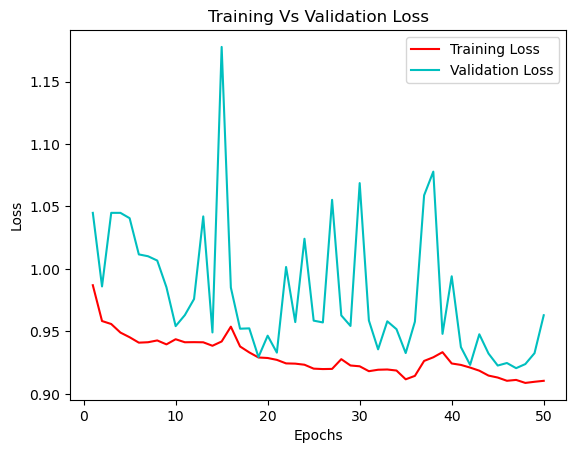

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'c', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [20]:
y_pred_pspnet = pspnet_model.predict(test_images)
y_pred_pspnet_argmax = np.argmax(y_pred_pspnet, axis=-1)

4/4 [==============================] - 31s 3s/step


In [21]:
y_test = to_categorical(test_masks, num_classes = 5)
y_test_argmax = np.argmax(y_test, axis=3)

## model evaluation

In [39]:
_, acc = pspnet_model.evaluate(test_images, y_pred_pspnet)
print("Accuracy is = ", (acc * 100.0), "%")

4/4 [==============================] - 2s 461ms/step - loss: 0.8655 - accuracy: 1.0000 - jaccard_coef: 0.9192


TypeError: can't multiply sequence by non-int of type 'float'

## prediction visualisation

1/1 [==============================] - 0s 24ms/step


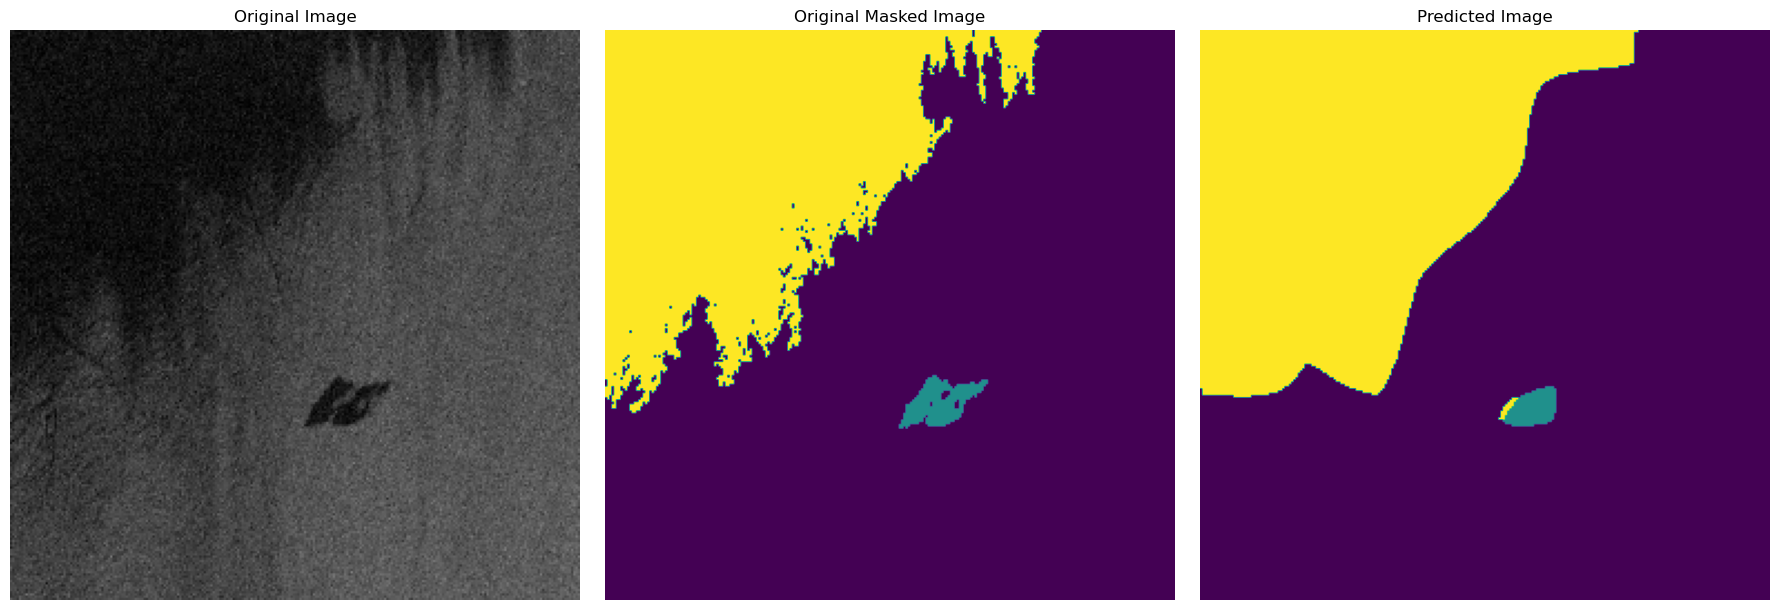

In [38]:
# Generate a random index within the range of test_images
test_image_number = random.randint(0, len(test_images) - 1)

# Retrieve the test image and its corresponding ground truth
test_image = test_images[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

# Expand dimensions of the test image to match the model input shape
test_image_input = np.expand_dims(test_image, axis=0)

# Get the model's prediction for the test image
prediction = pspnet_model.predict(test_image_input)

# Find the index of the highest predicted value along the channel axis
predicted_image = np.argmax(prediction, axis=3)[0, :, :]

# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the original image
axes[0].imshow(test_image)
axes[0].set_title("Original Image")
axes[0].axis('off')  # Turn off axis labels

# Plot the original masked image
axes[1].imshow(ground_truth_image)
axes[1].set_title("Original Masked Image")
axes[1].axis('off')  # Turn off axis labels

# Plot the predicted image
axes[2].imshow(predicted_image)
axes[2].set_title("Predicted Image")
axes[2].axis('off')  # Turn off axis labels

# Adjust layout and spacing
plt.tight_layout()

# Display the plot
plt.show()